# STA 141C Project
- Exploratory data analysis 
- Logistic Regression
- LDA and QDA 
- Maybe more

In [13]:
# import basic packages for data analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import subplots
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor as RF

# import the packages/methods that related to the dataset
from ISLP import load_data
# from ISLP.models import ModelSpec as MS, summarize
from ISLP.models import summarize

In [33]:
# Load data
df = pd.read_csv("./north.csv")

In [34]:
# Check first 5 rows
print(df.head())

# Get the shape of data
print(df.shape)

# Get the columns of the data
print(df.columns)

   index        Data   Hora  PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0      0  2000-05-09  00:00                           -9999.0   
1      1  2000-05-09  01:00                           -9999.0   
2      2  2000-05-09  02:00                           -9999.0   
3      3  2000-05-09  03:00                           -9999.0   
4      4  2000-05-09  04:00                           -9999.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                            -9999.0       
1                                            -9999.0       
2                                            -9999.0       
3                                            -9999.0       
4                                            -9999.0       

   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                          -9999.0   
1                                          -9999.0   
2                                          -9999.0   
3                               

Given that the column names are in Portugese, it would be ideal to change these names to English for ease of understanding. In addition, there are many -9999 values evident in the first 10 printed rows of the data, which might be indicative of NaN values, which we would be dealing with later on.

In [35]:
# Change column headers to shortened english labels
column_name_english = ['idx', 'date','hour','tPrec','atmosPStatn','prevHrPmax','prevHrPmin','rad','airTemp','dpTemp','prevHrMaxTemp','prevHrMinTemp','prevHrMaxDpTemp','prevHrMinDpTemp','prevHrMaxHum','prevHrMinHum','airHum','windDir','maxWindSp','windSp','reg','state','statn','statnCode','lat','long','height']
df.columns = column_name_english

There are object types present in the dataset on top of int and floats. We would need to convert these types to numeric types in order to perform a regression analysis that predicts the temperature.

In [16]:
# Get detailed info of dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392320 entries, 0 to 8392319
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   idx              int64  
 1   date             object 
 2   hour             object 
 3   tPrec            float64
 4   atmosPStatn      float64
 5   prevHrPmax       float64
 6   prevHrPmin       float64
 7   rad              int64  
 8   airTemp          float64
 9   dpTemp           float64
 10  prevHrMaxTemp    float64
 11  prevHrMinTemp    float64
 12  prevHrMaxDpTemp  float64
 13  prevHrMinDpTemp  float64
 14  prevHrMaxHum     int64  
 15  prevHrMinHum     int64  
 16  airHum           int64  
 17  windDir          int64  
 18  maxWindSp        float64
 19  windSp           float64
 20  reg              object 
 21  state            object 
 22  statn            object 
 23  statnCode        object 
 24  lat              float64
 25  long             float64
 26  height           float64
dtypes: float64(1

In [36]:
# Drop irrelavent columns 
df.drop(['idx'],inplace=True, axis=1)

# Replace all nan values and delete rows with nan values
df = df.replace(to_replace=-9999,value=np.NaN)
# Check for existence of nan values
print(df.isnull().sum())
# Drop all nans
df.dropna(inplace=True)

date                     0
hour                     0
tPrec              1988221
atmosPStatn        1591222
prevHrPmax         1597892
prevHrPmin         1597871
rad                4540804
airTemp            1551208
dpTemp             1706311
prevHrMaxTemp      1558370
prevHrMinTemp      1558241
prevHrMaxDpTemp    1713899
prevHrMinDpTemp    1715709
prevHrMaxHum       1707478
prevHrMinHum       1711836
airHum             1706495
windDir            1847536
maxWindSp          1810415
windSp             1797836
reg                      0
state                    0
statn                    0
statnCode                0
lat                      0
long                     0
height              273960
dtype: int64


From the below code, we infer that the station code uniquely identifies the station name, given that their numbers are approximately equal. However, for a particular station code, there may be multiple heights, latitudes of longitudes. For this reason, we have decided that variables such as altitude, longitude and height will be sufficient to uniquely identify a particular location, while station code, station name and region can be omitted in our analysis. 

In [37]:
# Shows one station can have multiple height variables
df_statnCode_A101 = df[df['statnCode'] == 'A101']
print(df_statnCode_A101['height'].value_counts())

# Remove non-important columns
df.drop(['statnCode', 'reg', 'state', 'statn' ],inplace=True, axis=1)


61.25    65272
48.79    19392
Name: height, dtype: int64


In order to change the date and time to a numerical value, we concatenate the date and time, then covert it to an ordinal value, which is a numerical representation for the date and time. This will be helpful as the traning data are formatted to only include numerical types, which is ideal for model training later on.

In [38]:
df['date_time'] = pd.to_datetime(df['date'] + ' ' +  df['hour'])
df.drop(['date', 'hour' ],inplace=True, axis=1)
df['date_time']=df['date_time'].map(dt.datetime.toordinal)

We can attempt to visualize the distribution of the response variable, airTemp, using a histogram and a boxplot as shown below. We can see that a significant proportion of the temperatures lie between 25 degrees and 32 degrees. However, we also realize that there is some data 17 degrees and below that fall outside the 1.5 x IQR range.

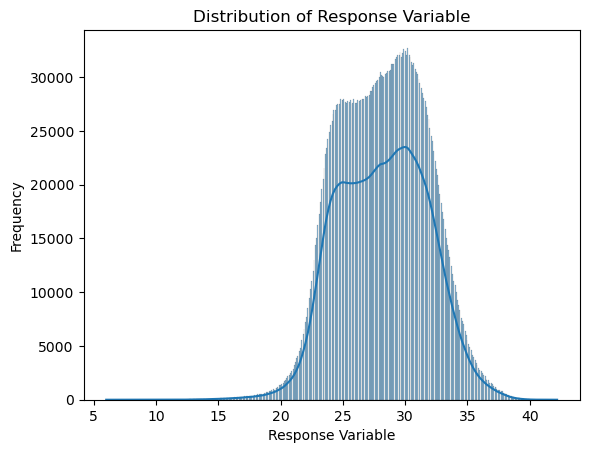

<AxesSubplot:ylabel='airTemp'>

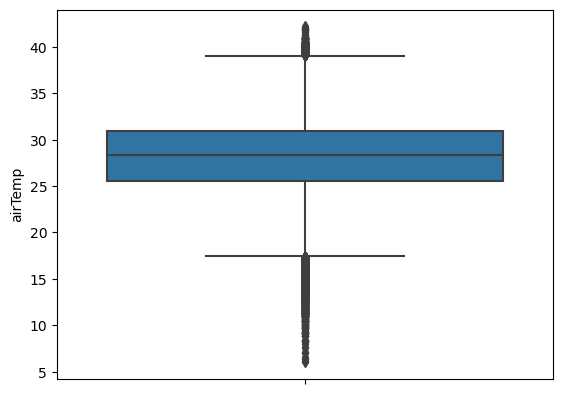

In [14]:
# Visualize the distribution of the response variable (airTemp)
sns.histplot(df['airTemp'], kde=True)
plt.title('Distribution of Response Variable')
plt.xlabel('Response Variable')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(y = df['airTemp'])

We then find the correlation matrix and split up the heatmap plots to be able to obtain a better visual representation of the correlations

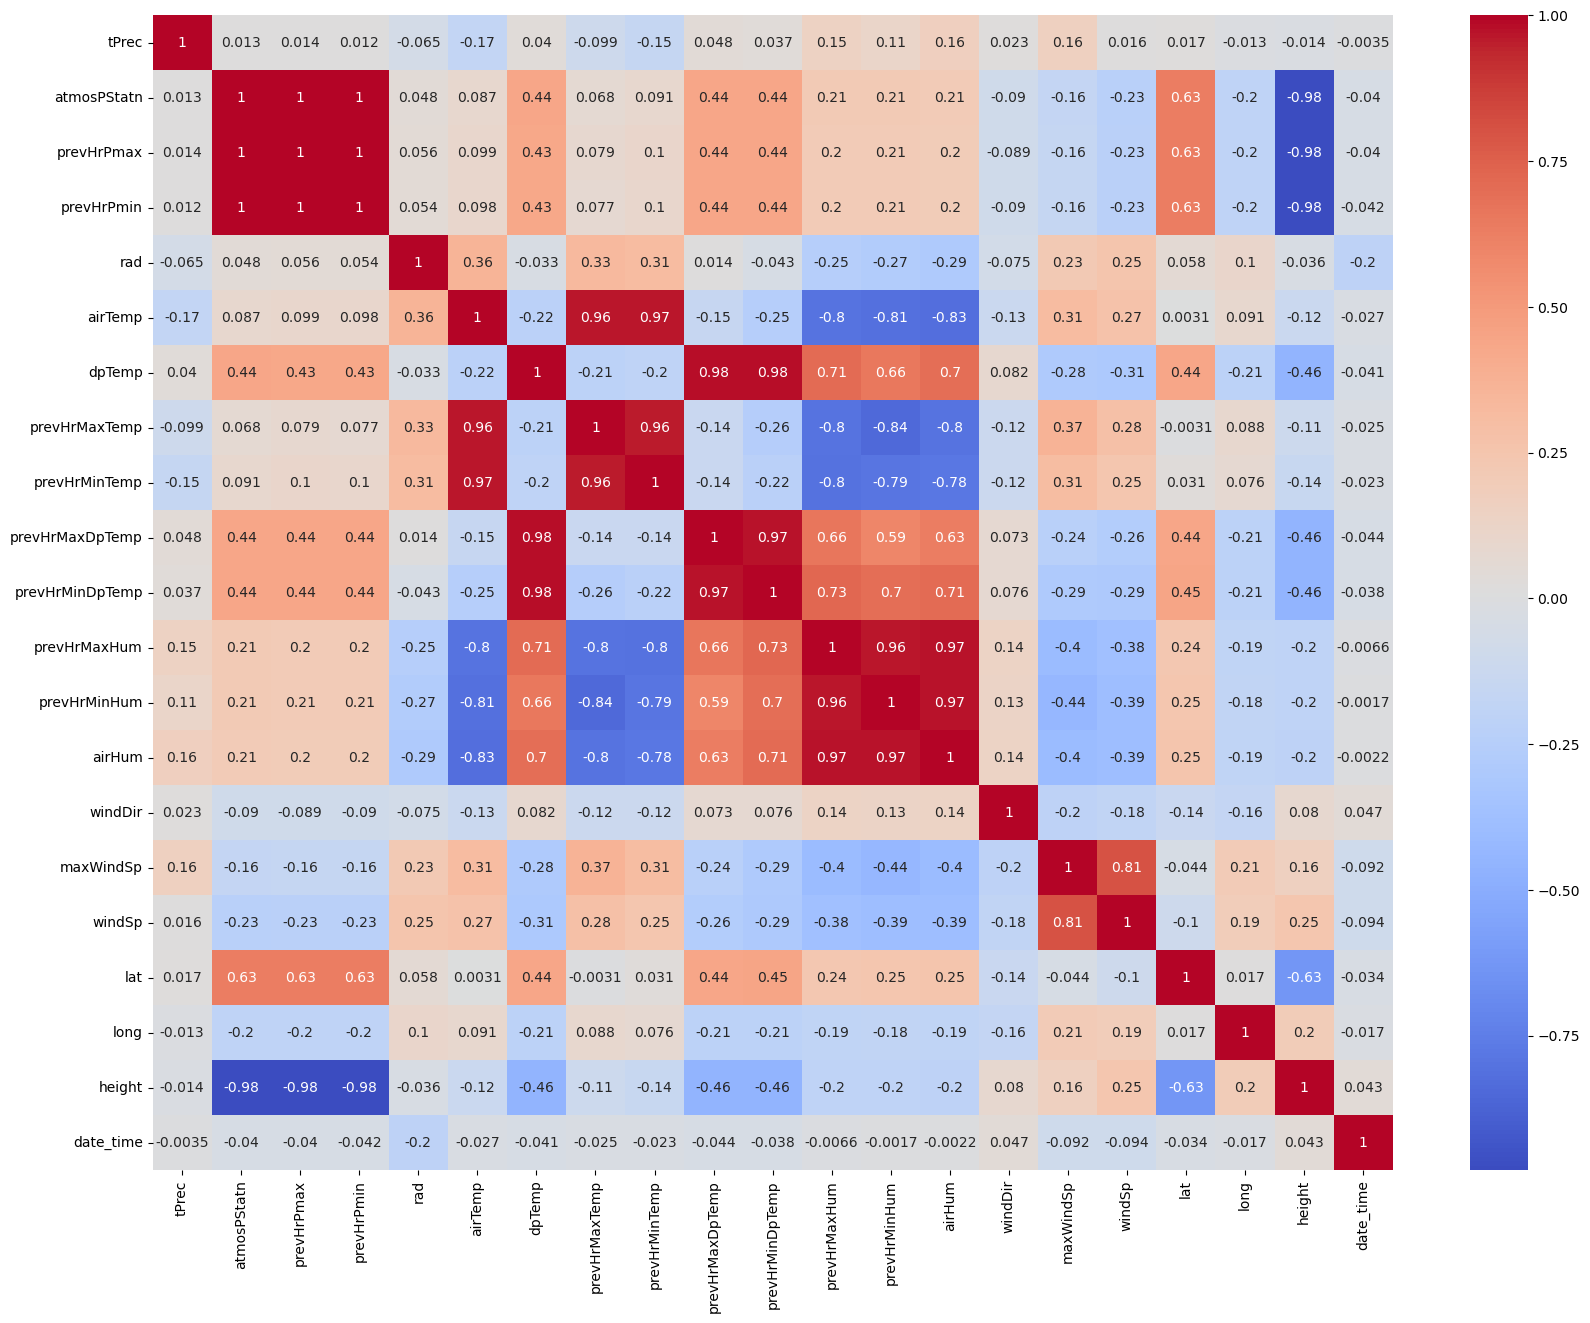

In [39]:
## get the correlation matrix of the data
corr_matrix = df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

For the code below, we plot a scatter plot for the top 9 variables that are correlated with airTemp. We can see that especially for the first two graphs, which are prevHrMinTemp and prevHrMaxTemp respectively, we can see a relatively linear relationship between these variables and airTemp. However for the rest of the graphs, the relationship with airtemp generally becomes less clear.

airTemp            1.000000
prevHrMinTemp      0.966455
prevHrMaxTemp      0.963276
airHum             0.825103
prevHrMinHum       0.810764
prevHrMaxHum       0.800382
rad                0.359995
maxWindSp          0.313604
windSp             0.267056
prevHrMinDpTemp    0.249279
dpTemp             0.216788
tPrec              0.171465
prevHrMaxDpTemp    0.146825
windDir            0.127466
height             0.122126
prevHrPmax         0.099273
prevHrPmin         0.097684
long               0.090917
atmosPStatn        0.087221
date_time          0.027103
lat                0.003129
Name: airTemp, dtype: float64
['prevHrMinTemp', 'prevHrMaxTemp', 'airHum', 'prevHrMinHum', 'prevHrMaxHum', 'rad', 'maxWindSp', 'windSp', 'prevHrMinDpTemp']


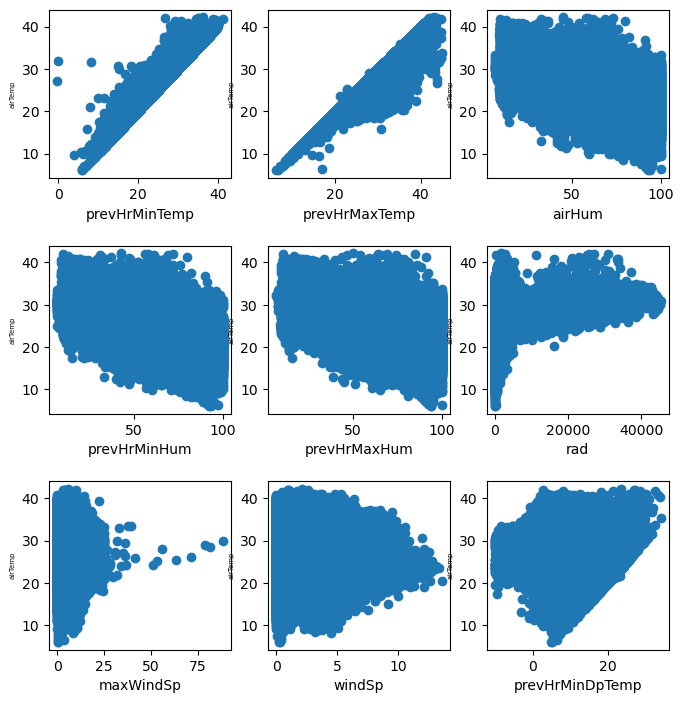

In [46]:
y_temp = df['airTemp']

# Find out the variables that are most correlated with airTemp
most_corr_df = corr_matrix['airTemp'].abs().sort_values(ascending=False)
print(most_corr_df)

# Get a list of top 10 most correlated variables
most_corr_var = list(most_corr_df.index.values)[:10]
most_corr_var.pop(0)
print(most_corr_var)

# create a figure and an axes object with a specific size for plotting
fig, ax = plt.subplots(3, 3, figsize=(8,8))
for j in range(len(most_corr_var)):
    row_idx = math.floor(j/3)
    col_idx = j % 3
    ax[row_idx, col_idx].scatter(df[most_corr_var[j]], y_temp)
    ax[row_idx, col_idx].set_xlabel(most_corr_var[j], fontsize=10) # set label for x axis
    ax[row_idx, col_idx].set_ylabel('airTemp', fontsize=5) # set label for y axis
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.4)
plt.show()


We see that atmosPstatn, the atmnospheric pressure at the station level is very highly correlated with prevHrPmin and prevHrPmax, as it is likely that any increases in the prevHrPmin or prevHrPmin would result in corresponding changes in the atmospheric pressure. Thus, we can proceed to omit prevHrPmin and prevHrPmax from our dataframe. Some other examples of high correlation is dewpoint temperature with prevHrMaxDpTemp and prevHrMinDpTemp, which is logical given that the min and max dewpoint temperature range in the previous would significantly influence the current dewpoint temperature, thus we can omit the prevHrMax and Min DpTemp from our dataframe. We will seek to drop variables that has a correlation value of more than 0.8 with another. After the drop operations, we are left with 11 predictor variables and 1 response variable.

In [20]:
# Removed as highly correlated with atmosPStatn
df.drop(['prevHrPmin', 'prevHrPmax'],inplace=True, axis=1)

# Removed as highly correlated with dpTemp
df.drop(['prevHrMaxDpTemp', 'prevHrMinDpTemp'],inplace=True, axis=1)

# Removed as highly correlated with prevHrMinTemp
df.drop(['prevHrMaxTemp'], inplace=True, axis=1)

# Removed as highly correlated with dpTemp
df.drop(['prevHrMaxHum', 'prevHrMinHum'],inplace=True, axis=1)

# Removed as highly correlated with windSp
df.drop(['maxWindSp'], inplace=True, axis=1)

# Removed as highly correlated with atmosPStatn
df.drop(['height'], inplace=True, axis=1)

In [21]:
def split_group(group):
    # Sort values in asecending ordinal date_time
    group = group.sort_values(by='date_time')
    # Non-random, ordered train-test split
    train_set, test_set = train_test_split(group, test_size=0.3, shuffle = False, stratify = None)
    return train_set, test_set

# Group by combination of latitude and longitude
group = df.groupby(['lat', 'long'])

# Apply the split_group function to each group
train_test_sets = group.apply(split_group)

# Construct the train and test set dataframes
train_set = pd.concat([x[0] for x in train_test_sets])
train_set.reset_index(drop=True, inplace=True)

test_set = pd.concat([x[1] for x in train_test_sets])
test_set.reset_index(drop=True, inplace=True)

X_train = train_set.drop(['airTemp'], axis=1)
y_train = train_set['airTemp']
X_test = test_set.drop(['airTemp'], axis=1)
y_test = test_set['airTemp']


We will now attempt to fit a simple bagging model to the data and see how well it performs with the test dataset. We generate 100 trees to fit the data by using the default value of the n_estimator parameter. For now, training the bagging model consumes too much time, as it was running for 30 minutes without any output. Thus, given the size of the dataset, the bagging model may not be suitable


In [12]:
# create the random forest model, setting max_features=X_train.shape[1] to do the bagging method
# Default value for n_estimators is 100 
bagging_weather = RF(max_features=X_train.shape[1], random_state=0)
# fit the model by the training data
bagging_weather.fit(X_train, y_train)

bagging_y_pred = bagging_weather.predict(X_test)
np.mean((y_test - bagging_y_pred)**2)

KeyboardInterrupt: 

We will now attempt to fit a simple Random Forrest model to the data and see how well it performs with the test dataset. Similar to bagging, we will generate 100 trees to fit the model, but will limit the number of features to be taken into account to be 6. 


In [ ]:
RF_weather = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_weather.predict(X_test)

In [30]:
print(np.mean((y_test - y_hat_RF)**2))
print(np.mean(np.abs(y_test - y_hat_RF)))

0.03643217300158907
0.10974133908689959


                                 OLS Regression Results                                
Dep. Variable:                airTemp   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              3066.
Date:                Sat, 02 Mar 2024   Prob (F-statistic):                        0.00
Time:                        23:08:36   Log-Likelihood:                     -1.0881e+07
No. Observations:             2286285   AIC:                                  2.176e+07
Df Residuals:                 2286273   BIC:                                  2.176e+07
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [151]:
MSE_OLS = (np.sum((y_test-probs) ** 2))/y_test.shape[0]
print(MSE_OLS)

print(y_test)
print(probs)

print(df.columns)
print(df.head())

797.1261939675896
1021212    27.4
6143476    22.9
7547877    37.1
5665297    30.1
6052190    32.8
           ... 
1973491    28.9
3909573    30.6
5627279    23.9
7237190    30.7
6976728    32.5
Name: airTemp, Length: 979837, dtype: float64
[-0.83342335 -5.33342335  8.86657665 ... -4.33342335  2.46657665
  4.26657665]
Index(['tPrec', 'atmosPStatn', 'rad', 'airTemp', 'dpTemp', 'prevHrMinTemp',
       'airHum', 'windDir', 'windSp', 'lat', 'long', 'date_time'],
      dtype='object')
    tPrec  atmosPStatn    rad  airTemp  dpTemp  prevHrMinTemp  airHum  \
21    0.0       1002.6  386.0     29.4    23.1           29.4    69.0   
22    0.0       1002.8  184.0     26.9    24.1           26.9    84.0   
35    0.0       1006.8  207.0     25.2    24.5           23.9    96.0   
36    0.0       1007.7  745.0     27.1    25.2           25.2    89.0   
37    0.0       1008.3  916.0     28.1    23.8           26.9    78.0   

    windDir  windSp       lat       long  date_time  
21     96.0     0.8 -3.

By plotting the data we see that Volume is increasing over time. In other words, the average number of shares traded
daily increased from 2001 to 2005

In [143]:
# pair plots
sns.pairplot(Smarket, hue='Direction')

NameError: name 'Smarket' is not defined

From the pairplot, we can see that
- 1. There is no colinearity/ high correlation between predictors.
- 2. The `Direction` is highly related to `Today`. 

## Logistic Regression



Now, let's fit a logistic regression model in order to predict `Direction` using `Lag1` through `Lag5` and `Volume`. 

### Using sm.GLM()
The sm.GLM() function fts generalized linear models, a class of models that includes logistic regression.

In [ ]:
from ISLP.models import (ModelSpec as MS, summarize)

allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
# create the design matrix X
X = design.fit_transform(Smarket)
# y =1 <--> 'up' y = 0 <--> 'down'
y = Smarket.Direction == 'Up'
# create the logistic regression model using sm.GLM
glm = sm.GLM(y, X, family=sm.families.Binomial())
# fit the model
results = glm.fit()
# showing the results
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


The smallest p-value here is associated with Lag1. The negative coefcient
for this predictor suggests that if the market had a positive return yesterday,
then it is less likely to go up today. However, at a value of 0.15, the p-value
is still relatively large, and so there is no clear evidence of a real association
between Lag1 and Direction.

In [ ]:
# get the estimated parameters
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [ ]:
# get the p-values
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [ ]:
## get the predicted probabilities
## if there is no data supplied to the predict funtion, then by default it predict the probability for the training dataset.
probs = results.predict()
probs

## only predict for the first two data points
# probs1 = results.predict(X[0:2])
# probs1

array([0.50708413, 0.48146788, 0.48113883, ..., 0.5392683 , 0.52611829,
       0.51791656])

In [ ]:
## covert probabilities to labels, like 'up' or 'down'
## if probability > 0.5 then 'up' else 'down'
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"
labels

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [ ]:
from ISLP import confusion_table

# calculate the confusion matrix
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [ ]:
## Calculate accuracy from the confusion matrix
print((145+507)/len(y))

## Calculate accuracy from labels
print(np.sum(labels == Smarket.Direction)/len(y))

0.5216
0.5216


### Train Test Split

Split the data into training and test datasets in order to better assess
the accuracy of the logistic regression model. 

Let's use the data before 2005 as our training data and then predict for years 2005 and after.

In [ ]:
Smarket_train = Smarket.loc[Smarket.Year < 2005]
Smarket_test = Smarket.loc[Smarket.Year >= 2005]
Smarket_test.shape

(252, 9)

In [ ]:
# an indicator vector showing whether the data point is in the training set or not
train = Smarket.Year < 2005
# split X and y
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
# fit the model on the training set
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
# predict on the test set
probs = results.predict(exog=X_test)

In [ ]:
# split the true labels to training and test sets
L_train, L_test = Smarket.Direction.loc[train], Smarket.Direction.loc[~train]

# calculate the confusion matrix for test set
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [ ]:
# calculate the test accuracy and test error
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

The test accuracy is about 48% while the error rate is about 52% which is worse than random guessing.

Let's remove the predictors that have large p-values to create a more effective model. 

In [ ]:
# only use 'Lag1' and 'Lag2' fit the model
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [ ]:
# calculate the test accuracy and true positive rate
np.mean(labels == L_test), 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

Conclusion: The results appear to be a little better: 56% of the daily movements
have been correctly predicted. It is worth noting that in this case, a much
simpler strategy of predicting that the market will increase every day will
also be correct 56% of the time! Hence, in terms of overall error rate, the
logistic regression method is no better than the naive approach. However,
the confusion matrix shows that on days when logistic regression predicts
an increase in the market, it has a 58% accuracy rate. This suggests a
possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted.
Of course one would need to investigate more carefully whether this small
improvement was real or just due to random chance.

In [ ]:
# predict for new data
newdata = pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1, -0.8]})
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

## LDA 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
# an indicator vector showing whether the data point is in the training set or not
train = Smarket.Year < 2005

X_train = Smarket[['Lag1','Lag2']].loc[train]
X_test = Smarket[['Lag1','Lag2']].loc[~train]

y_train, y_test = Smarket.Direction.loc[train],  Smarket.Direction.loc[~train]

lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)


LinearDiscriminantAnalysis(store_covariance=True)

In [ ]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [ ]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [ ]:
lda.priors_

In [ ]:
lda.scalings_

In [ ]:
lda_pred = lda.predict(X_test)

In [ ]:
confusion_table(lda_pred, L_test)

In [ ]:
lda_prob = lda.predict_proba(X_test)

## QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)